##### Importing libraries

In [21]:
import pandas as pd
import re
from unidecode import unidecode
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import random
import seaborn as sns

In [22]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#### NaiveBayes class

In [23]:
class NB:
    #Class to String
    num2str = {
        0: 'Negative',
        1: 'Neutral',
        2: 'Positive'
    }   
    
    #String to Class
    str2num = {
        'Negative': 0,
        'Neutral': 1,
        'Positive': 2
    }
    
    #To remove the pattern in a string given a pattern
    @staticmethod
    def remove_pattern(string, pattern):
        r = re.findall(pattern, string)
        for word in r:
            string = re.sub(word, " ", string)
        return string
    
    #Returns a list of words given a string
    @staticmethod
    def initial_preprocess(text, use_stem_remove_stopwords):
        # Remove "\r\n" characters
        temp = text.replace("\r", " ").replace("\n", " ")
        #remove userhandles
        temp = NB.remove_pattern(temp, "@\w+")
        #remove hashtags
        temp = NB.remove_pattern(temp, "#\w+")
        #remove urls
        temp = re.sub(r'http\S+', ' ', temp.strip())
        #replace diacritic texts
        temp = unidecode(temp)
        # Remove special characters (except alphanumeric characters and spaces)
        temp = re.sub(r'[^\w\s]', ' ', temp.strip())
        #remove full stops and comma
        temp = temp.replace('.', ' ').replace(',', ' ')
        # Remove multiple spaces
        temp = re.sub(r'\s+', ' ', temp.strip())
        #Lowercase a string
        temp = temp.lower()

        # Tokenize
        words = temp.lower().split()
        #remove integer strings
        words = [w for w in words if not w.isdigit()]

        if use_stem_remove_stopwords:
            #Remove stopwords
            english_stopwords = stopwords.words('english')
            words = [w for w in words if w not in english_stopwords]

            #Stemming
            ps = PorterStemmer()
            words = [ps.stem(w) for w in words]

        return words
    
    #Return the probability of y given x
    @staticmethod
    def get_probability_y_given_x(tokens, phi, theta, denom, V, use_bigrams, use_trigrams):
        p = np.log(phi)
        for token in tokens:
            # Laplace smoothing
            if theta[token] == 0:
                p += np.log(1/V)
            else:
                p += np.log((theta[token]+1)/(denom+V))
            
        if use_bigrams:
            for j in range(len(tokens)-1):
                pair = tokens[j]+' '+tokens[j+1]
                if theta[pair] == 0:
                    p += np.log(1/V)
                else:
                    p += np.log((theta[pair]+1)/(denom+V))
                    
        if use_trigrams:
            for j in range(len(tokens)-2):
                triad = tokens[j]+' '+tokens[j+1]+' '+tokens[j+2]
                if theta[triad] == 0:
                    p += np.log(1/V)
                else:
                    p += np.log((theta[triad]+1)/(denom+V))
                    
#         for token in tokens:
#             # Laplace smoothing
#             p += np.log((theta[token]+1)/(denom+V))
            
#         if use_bigrams:
#             for j in range(len(tokens)-1):
#                 pair = tokens[j]+' '+tokens[j+1]
#                 p += np.log((theta[pair]+1)/(denom+V))
                
#         if use_trigrams:
#             for j in range(len(tokens)-2):
#                 triad = tokens[j]+' '+tokens[j+1]+' '+tokens[j+2]
#                 p += np.log((theta[triad]+1)/(denom+V))
        
        return p
    
    def __init__(self, train_df, use_bigrams, use_trigrams, use_stem_remove_stopwords, da=False):
        #To store the dataframe
        self.train_df = train_df
        
        #Set use_bigrams
        self.use_bigrams = use_bigrams
        
        #Set use_trigrams
        self.use_trigrams = use_trigrams
        
        #Set use_stem_remove_stopwords
        self.use_stem_remove_stopwords = use_stem_remove_stopwords
        
        #To store the count of tokens for each class
        self.pos_tokens = defaultdict(lambda:0)
        self.neg_tokens = defaultdict(lambda:0)
        self.neu_tokens = defaultdict(lambda:0)
        
        self.vocabulary = []
        self.V = 0
        
        self.m = len(self.train_df)
#         self.V = len(self.vocabulary)

        #True if dealing with domain adaptation dataset
        self.da = da

        #Parameters of Naive Bayes
        ## Prior
        self.phi_y0 = 0
        self.phi_y1 = 0
        self.phi_y2 = 0
        
        ## Count of words of each class
        self.denom_y0 = 0
        self.denom_y1 = 0
        self.denom_y2 = 0
        
    def calculate_prior(self):
        # Phi parameters initialization
        for i in range(len(self.train_df)):    
            if self.train_df["Sentiment"][i] == "Negative":
                self.phi_y0 += 1
            if self.train_df["Sentiment"][i] == "Neutral":
                self.phi_y1 += 1
            if self.train_df["Sentiment"][i] == "Positive":
                self.phi_y2 += 1

        self.phi_y0 /= self.m
        self.phi_y1 /= self.m
        self.phi_y2 /= self.m
        
    def unigram_counts(self):
        # Compute the count of each word and store it in a dictionary
        for i in range(self.m):
            if self.da:
                text = NB.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            else:
                text = NB.initial_preprocess(self.train_df["CoronaTweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for txt in text:
                    if txt in self.pos_tokens:
                        self.pos_tokens[txt] += 1
                    else:
                        self.pos_tokens[txt] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for txt in text:
                    if txt in self.neg_tokens:
                        self.neg_tokens[txt] += 1
                    else:
                        self.neg_tokens[txt] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for txt in text:
                    if txt in self.neu_tokens:
                        self.neu_tokens[txt] += 1
                    else:
                        self.neu_tokens[txt] = 1
    
    def bigram_counts(self):
        # Compute the count of each bigram and store it in a dictionary
        for i in range(self.m):
            if self.da:
                text = NB.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            else:
                text = NB.initial_preprocess(self.train_df["CoronaTweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.pos_tokens:
                        self.pos_tokens[pair] += 1
                    else:
                        self.pos_tokens[pair] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.neg_tokens:
                        self.neg_tokens[pair] += 1
                    else:
                        self.neg_tokens[pair] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.neu_tokens:
                        self.neu_tokens[pair] += 1
                    else:
                        self.neu_tokens[pair] = 1
                        
    def trigram_counts(self):
        # Compute the count of each trigram and store it in a dictionary
        for i in range(self.m):
            if self.da:
                text = NB.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            else:
                text = NB.initial_preprocess(self.train_df["CoronaTweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.pos_tokens:
                        self.pos_tokens[triad] += 1
                    else:
                        self.pos_tokens[triad] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.neg_tokens:
                        self.neg_tokens[triad] += 1
                    else:
                        self.neg_tokens[triad] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.neu_tokens:
                        self.neu_tokens[triad] += 1
                    else:
                        self.neu_tokens[triad] = 1
                    
    
    def train_the_parameters(self):
        self.unigram_counts()
        if self.use_bigrams:
            self.bigram_counts()
        if self.use_trigrams:
            self.trigram_counts()
        
    def set_derived_parameters(self):
        # Compute parameters like V, sum count of each classes
        self.vocabulary = list(self.pos_tokens.keys()) + list(self.neg_tokens.keys()) + list(self.neu_tokens.keys())
        self.vocabulary = set(self.vocabulary)
        self.V = len(self.vocabulary)
        
        self.denom_y0 = sum(list(self.neg_tokens.values()))
        self.denom_y1 = sum(list(self.neu_tokens.values()))
        self.denom_y2 = sum(list(self.pos_tokens.values()))
        
    def predict_on_testdata(self, test_df):
        test_df = test_df.reindex(columns=list(test_df.columns)+["Sentiment_pred_initial"])
        for i in range(len(test_df)):
            if self.da:
                tokens = NB.initial_preprocess(test_df["Tweet"][i], self.use_stem_remove_stopwords)
            else:
                tokens = NB.initial_preprocess(test_df["CoronaTweet"][i], self.use_stem_remove_stopwords)
            p_y0_given_x = NB.get_probability_y_given_x(tokens, self.phi_y0, self.neg_tokens, self.denom_y0, self.V, self.use_bigrams, self.use_trigrams)
            p_y1_given_x = NB.get_probability_y_given_x(tokens, self.phi_y1, self.neu_tokens, self.denom_y1, self.V, self.use_bigrams, self.use_trigrams)
            p_y2_given_x = NB.get_probability_y_given_x(tokens, self.phi_y2, self.pos_tokens, self.denom_y2, self.V, self.use_bigrams, self.use_trigrams)
            arr = np.array([p_y0_given_x,p_y1_given_x,p_y2_given_x])
#             test_df["Sentiment_pred_initial"][i] = NB.num2str[np.argmax(arr)]
            test_df.at[i,"Sentiment_pred_initial"] = NB.num2str[np.argmax(arr)]
            
        #Accuracy
        acc = 0
        for i in range(len(test_df)):
            if test_df["Sentiment"][i] == test_df["Sentiment_pred_initial"][i]:
                acc += 1
        acc = (acc*100)/len(test_df)
        print("Accuracy: ", acc)
        return test_df
    
    @staticmethod
    def confusion_matrix(y_actual, y_predicted):
        #Creates a confusion matrix given y_actual and y_predicted
        conf_mat = np.zeros((3,3))
        for i in range(len(y_actual)):
            conf_mat[NB.str2num[y_actual[i]]][NB.str2num[y_predicted[i]]] += 1

        fig = plt.figure(figsize=(8,6))
        ax = plt.subplot()
        sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g')
        ax.set_xlabel("Predicted", fontsize=20)
        ax.xaxis.set_label_position('bottom')
        plt.xticks(rotation=90)
        ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        ax.xaxis.tick_bottom()

        ax.set_ylabel('Actual', fontsize=20)
        ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        plt.yticks(rotation=0)

        plt.title("Confusion Matrix", fontsize = 20)

        plt.show()
        
    @staticmethod
    def plot_wordcloud(dictionary):
        #Creates a wordcloud given a dictionary 
        wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dictionary)
        plt.figure(figsize=(10,10))
        plt.imshow(wc,interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    def execute(self):
        self.calculate_prior()
        self.train_the_parameters()
        self.set_derived_parameters()
        

##### Naive Bayes with domain adaptation

In [24]:
#Naive Bayes domain adaptation version
class NB_da:
    #Class to String
    num2str = {
        0: 'Negative',
        1: 'Neutral',
        2: 'Positive'
    }   
    
    #String to Class
    str2num = {
        'Negative': 0,
        'Neutral': 1,
        'Positive': 2
    }
    
    #To remove the pattern in a string given a pattern
    @staticmethod
    def remove_pattern(string, pattern):
        r = re.findall(pattern, string)
        for word in r:
            string = re.sub(word, " ", string)
        return string
    
    #Returns a list of words given a string
    @staticmethod
    def initial_preprocess(text, use_stem_remove_stopwords):
        # Remove "\r\n" characters
        temp = text.replace("\r", " ").replace("\n", " ")
        #remove userhandles
        temp = NB_da.remove_pattern(temp, "@\w+")
        #remove hashtags
        temp = NB_da.remove_pattern(temp, "#\w+")
        #remove urls
        temp = re.sub(r'http\S+', ' ', temp.strip())
        #replace diacritic texts
        temp = unidecode(temp)
        # Remove special characters (except alphanumeric characters and spaces)
        temp = re.sub(r'[^\w\s]', ' ', temp.strip())
        #remove full stops and comma
        temp = temp.replace('.', ' ').replace(',', ' ')
        # Remove multiple spaces
        temp = re.sub(r'\s+', ' ', temp.strip())
        #Lowercase a string
        temp = temp.lower()

        # Tokenize
        words = temp.lower().split()
        #remove integer strings
        words = [w for w in words if not w.isdigit()]

        if use_stem_remove_stopwords:
            #Remove stopwords
            english_stopwords = stopwords.words('english')
            words = [w for w in words if w not in english_stopwords]

            #Stemming
            ps = PorterStemmer()
            words = [ps.stem(w) for w in words]

        return words
    
    #Return the probability of y given x
    @staticmethod
    def get_probability_y_given_x(tokens, phi, theta, denom, V, use_bigrams, use_trigrams):
        p = np.log(phi)
        for token in tokens:
            # Laplace smoothing
            if theta[token] == 0:
                p += np.log(1/V)
            else:
                p += np.log((theta[token]+1)/(denom+V))
            
        if use_bigrams:
            for j in range(len(tokens)-1):
                pair = tokens[j]+' '+tokens[j+1]
                if theta[pair] == 0:
                    p += np.log(1/V)
                else:
                    p += np.log((theta[pair]+1)/(denom+V))
                    
        if use_trigrams:
            for j in range(len(tokens)-2):
                triad = tokens[j]+' '+tokens[j+1]+' '+tokens[j+2]
                if theta[triad] == 0:
                    p += np.log(1/V)
                else:
                    p += np.log((theta[triad]+1)/(denom+V))
                    
#         for token in tokens:
#             # Laplace smoothing
#             p += np.log((theta[token]+1)/(denom+V))
            
#         if use_bigrams:
#             for j in range(len(tokens)-1):
#                 pair = tokens[j]+' '+tokens[j+1]
#                 p += np.log((theta[pair]+1)/(denom+V))
            
#         if use_trigrams:
#             for j in range(len(tokens)-2):
#                 triad = tokens[j]+' '+tokens[j+1]+' '+tokens[j+2]
#                 p += np.log((theta[triad]+1)/(denom+V))

        return p
    
    def __init__(self, train_df, old_train_df, pos_tokens, neu_tokens, neg_tokens, use_bigrams, use_trigrams, use_stem_remove_stopwords):
        #To store the dataframe
        self.train_df = train_df
        
        self.old_train_df = old_train_df
        
        #Set use_bigrams
        self.use_bigrams = use_bigrams
        
        #Set use_trigrams
        self.use_trigrams = use_trigrams
        
        #Set use_stem_remove_stopwords
        self.use_stem_remove_stopwords = use_stem_remove_stopwords
        
        #To store the count of tokens for each class
        self.pos_tokens = pos_tokens
        self.neg_tokens = neg_tokens
        self.neu_tokens = neu_tokens
        
        self.vocabulary = []
        self.V = 0
        
        self.m = len(self.train_df)
#         self.V = len(self.vocabulary)

        #Parameters of Naive Bayes
        ## Prior
        self.phi_y0 = 0
        self.phi_y1 = 0
        self.phi_y2 = 0
        
        ## Count of words of each class
        self.denom_y0 = 0
        self.denom_y1 = 0
        self.denom_y2 = 0
        
    def calculate_prior(self):
        # Phi parameters initialization
        for i in range(len(self.old_train_df)):
            if self.old_train_df["Sentiment"][i] == "Negative":
                self.phi_y0 += 1
            if self.old_train_df["Sentiment"][i] == "Neutral":
                self.phi_y1 += 1
            if self.old_train_df["Sentiment"][i] == "Positive":
                self.phi_y2 += 1
        
        for i in range(len(self.train_df)):    
            if self.train_df["Sentiment"][i] == "Negative":
                self.phi_y0 += 1
            if self.train_df["Sentiment"][i] == "Neutral":
                self.phi_y1 += 1
            if self.train_df["Sentiment"][i] == "Positive":
                self.phi_y2 += 1

        self.phi_y0 /= (self.m+len(self.old_train_df))
        self.phi_y1 /= (self.m+len(self.old_train_df))
        self.phi_y2 /= (self.m+len(self.old_train_df))
        
    def unigram_counts(self):
        # Compute the count of each word and store it in a dictionary
        for i in range(self.m):
            text = NB_da.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for txt in text:
                    if txt in self.pos_tokens:
                        self.pos_tokens[txt] += 1
                    else:
                        self.pos_tokens[txt] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for txt in text:
                    if txt in self.neg_tokens:
                        self.neg_tokens[txt] += 1
                    else:
                        self.neg_tokens[txt] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for txt in text:
                    if txt in self.neu_tokens:
                        self.neu_tokens[txt] += 1
                    else:
                        self.neu_tokens[txt] = 1
    
    def bigram_counts(self):
        # Compute the count of each bigram and store it in a dictionary
        for i in range(self.m):
            text = NB_da.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.pos_tokens:
                        self.pos_tokens[pair] += 1
                    else:
                        self.pos_tokens[pair] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.neg_tokens:
                        self.neg_tokens[pair] += 1
                    else:
                        self.neg_tokens[pair] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for j in range(len(text)-1):
                    pair = text[j]+' '+text[j+1]
                    if pair in self.neu_tokens:
                        self.neu_tokens[pair] += 1
                    else:
                        self.neu_tokens[pair] = 1
                        
    def trigram_counts(self):
        # Compute the count of each trigram and store it in a dictionary
        for i in range(self.m):
            text = NB_da.initial_preprocess(self.train_df["Tweet"][i], self.use_stem_remove_stopwords)
            if self.train_df["Sentiment"][i] == "Positive":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.pos_tokens:
                        self.pos_tokens[triad] += 1
                    else:
                        self.pos_tokens[triad] = 1
            if self.train_df["Sentiment"][i] == "Negative":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.neg_tokens:
                        self.neg_tokens[triad] += 1
                    else:
                        self.neg_tokens[triad] = 1
            if self.train_df["Sentiment"][i] == "Neutral":
                for j in range(len(text)-2):
                    triad = text[j]+' '+text[j+1]+' '+text[j+2]
                    if triad in self.neu_tokens:
                        self.neu_tokens[triad] += 1
                    else:
                        self.neu_tokens[triad] = 1
                    
    
    def train_the_parameters(self):
        self.unigram_counts()
        if self.use_bigrams:
            self.bigram_counts()
        if self.use_trigrams:
            self.trigram_counts()
        
    def set_derived_parameters(self):
        # Compute parameters like V, sum count of each classes
        self.vocabulary = list(self.pos_tokens.keys()) + list(self.neg_tokens.keys()) + list(self.neu_tokens.keys())
        self.vocabulary = set(self.vocabulary)
        self.V = len(self.vocabulary)
        
        self.denom_y0 = sum(list(self.neg_tokens.values()))
        self.denom_y1 = sum(list(self.neu_tokens.values()))
        self.denom_y2 = sum(list(self.pos_tokens.values()))
        
    def predict_on_testdata(self, test_df):
        test_df = test_df.reindex(columns=list(test_df.columns)+["Sentiment_pred_da"])
        for i in range(len(test_df)):
            tokens = NB_da.initial_preprocess(test_df["Tweet"][i], self.use_stem_remove_stopwords)
            p_y0_given_x = NB_da.get_probability_y_given_x(tokens, self.phi_y0, self.neg_tokens, self.denom_y0, self.V, self.use_bigrams, self.use_trigrams)
            p_y1_given_x = NB_da.get_probability_y_given_x(tokens, self.phi_y1, self.neu_tokens, self.denom_y1, self.V, self.use_bigrams, self.use_trigrams)
            p_y2_given_x = NB_da.get_probability_y_given_x(tokens, self.phi_y2, self.pos_tokens, self.denom_y2, self.V, self.use_bigrams, self.use_trigrams)
            arr = np.array([p_y0_given_x,p_y1_given_x,p_y2_given_x])
#             test_df["Sentiment_pred_initial"][i] = NB.num2str[np.argmax(arr)]
            test_df.at[i,"Sentiment_pred_da"] = NB_da.num2str[np.argmax(arr)]
            
        #Accuracy
        acc = 0
        for i in range(len(test_df)):
            if test_df["Sentiment"][i] == test_df["Sentiment_pred_da"][i]:
                acc += 1
        acc = (acc*100)/len(test_df)
        print("Accuracy: ", acc)
        return test_df
    
    @staticmethod
    def confusion_matrix(y_actual, y_predicted):
        #Creates a confusion matrix given y_actual and y_predicted
        conf_mat = np.zeros((3,3))
        for i in range(len(y_actual)):
            conf_mat[NB_da.str2num[y_actual[i]]][NB_da.str2num[y_predicted[i]]] += 1

        fig = plt.figure(figsize=(8,6))
        ax = plt.subplot()
        sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g')
        ax.set_xlabel("Predicted", fontsize=20)
        ax.xaxis.set_label_position('bottom')
        plt.xticks(rotation=90)
        ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        ax.xaxis.tick_bottom()

        ax.set_ylabel('Actual', fontsize=20)
        ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        plt.yticks(rotation=0)

        plt.title("Confusion Matrix", fontsize = 20)

        plt.show()
        
    @staticmethod
    def plot_wordcloud(dictionary):
        #Creates a wordcloud given a dictionary 
        wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dictionary)
        plt.figure(figsize=(10,10))
        plt.imshow(wc,interpolation='bilinear')
        plt.axis('off')
        plt.show()
    
    def execute(self):
        self.calculate_prior()
        self.train_the_parameters()
        self.set_derived_parameters()
        

##### Word Score [feature engineering]

In [74]:
class WordScore:
    #String to Class
    str2num = {
        'Negative': 0,
        'Neutral': 1,
        'Positive': 2
    }
    
    def __init__(self, train_df, pos_tokens, neu_tokens, neg_tokens):
        #To store the training data
        self.train_df = train_df
        
        #To store the positive,neutral and negative tokens with their count
        self.pos_tokens = pos_tokens
        self.neu_tokens = neu_tokens
        self.neg_tokens = neg_tokens
        
        #To store all the unique words in a dictionary
        self.vocabulary = list(self.pos_tokens.keys()) + list(self.neg_tokens.keys()) + list(self.neu_tokens.keys())
        self.vocabulary = set(self.vocabulary)
        
        #To store the score for each words
        self.score_of_word = defaultdict(lambda:0)
        
        #invoke compute_word_scores
        self.compute_word_scores()
        
    def compute_word_scores(self):
        for word in self.vocabulary:
            # If word occurred atleast once in either positive or negative tweets
            if self.pos_tokens[word] != 0 or self.neg_tokens[word] != 0:
                arr = np.array([self.neg_tokens[word],self.neu_tokens[word],self.pos_tokens[word]])
                #proportion array
                prop_arr = arr / np.sum(arr)
                #temp_type stores the class which have max proportion
                temp_type = np.argmax(arr)
                
                #We assign scores to word depending on its proportion
                #NEGATIVE CASE
                if temp_type == 0:
                    #strong negative
                    if prop_arr[0] > 3 * prop_arr[2]:
                        self.score_of_word[word] = -1 * np.exp(abs(prop_arr[0]))
                    #weak negative
                    else:
                        self.score_of_word[word] = -1 * prop_arr[0]
                
                #NEUTRAL CASE
                elif temp_type == 1:
                    #slightly inclined towards negative
                    if prop_arr[0] > 3 * prop_arr[2]:
                        self.score_of_word[word] = -1 * prop_arr[0]
                    #slightly inclined towards positive
                    elif prop_arr[2] > 3 * prop_arr[0]:
                        self.score_of_word[word] = prop_arr[2]
                    else:
                        self.score_of_word[word] = 0
                        
                #POSITIVE CASE
                else:
                    #strong positive
                    if prop_arr[2] > 3 * prop_arr[0]:
                        self.score_of_word[word] = np.exp(abs(prop_arr[2]))
                    #weak positive
                    else:
                        self.score_of_word[word] = prop_arr[2]
                        
    def predict_on_testdata(self, test_df):
        test_df = test_df.reindex(columns=list(test_df.columns)+["Sentiment_pred_score"])

        for i in range(len(test_df)):
            tokens = NB.initial_preprocess(test_df["CoronaTweet"][i], True)
            score = 0
            for tok in tokens:
                score += self.score_of_word[tok]
            # print(f"{i}: {score} ", test_df["Sentiment"][i])
            
            #Depending on the value of score,we classify them to be either of three classes
            if score > 2:
                test_df.at[i,"Sentiment_pred_score"] = "Positive"
            elif score < 0:
                test_df.at[i,"Sentiment_pred_score"] = "Negative"
            else:
                test_df.at[i,"Sentiment_pred_score"] = "Neutral"
        
        return test_df
                
    @staticmethod
    def confusion_matrix(y_actual, y_predicted):
        #Creates a confusion matrix given y_actual and y_predicted
        conf_mat = np.zeros((3,3))
        for i in range(len(y_actual)):
            conf_mat[WordScore.str2num[y_actual[i]]][WordScore.str2num[y_predicted[i]]] += 1

        fig = plt.figure(figsize=(8,6))
        ax = plt.subplot()
        sns.heatmap(conf_mat, annot=True, ax = ax, fmt='g')
        ax.set_xlabel("Predicted", fontsize=20)
        ax.xaxis.set_label_position('bottom')
        plt.xticks(rotation=90)
        ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        ax.xaxis.tick_bottom()

        ax.set_ylabel('Actual', fontsize=20)
        ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'], fontsize = 10)
        plt.yticks(rotation=0)

        plt.title("Confusion Matrix", fontsize = 20)

        plt.show()            
    
    @staticmethod
    def print_accuracy(test_df):
        #Accuracy
        acc = 0
        for i in range(len(test_df)):
            if test_df["Sentiment"][i] == test_df["Sentiment_pred_score"][i]:
                acc += 1
        acc = (acc*100)/len(test_df)
        print("Accuracy: ", acc)
        
    def execute_and_test(self, test_df):
        self.compute_word_scores()
        test_df = self.predict_on_testdata(test_df)
        WordScore.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_score"])
        WordScore.print_accuracy(test_df)

##### Reading the train and test data

In [26]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')
test_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_validation.csv')

#### Naive Bayes without any stemming and stopwords removal

In [27]:
NaiveBayes = NB(train_df, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = False)
NaiveBayes.execute()

##### Training Accuracy

In [28]:
train_df = NaiveBayes.predict_on_testdata(train_df)

Accuracy:  59.53676315233467


##### Testing Accuracy

In [29]:
test_df = NaiveBayes.predict_on_testdata(test_df)

Accuracy:  66.0795627087762


##### Wordcloud

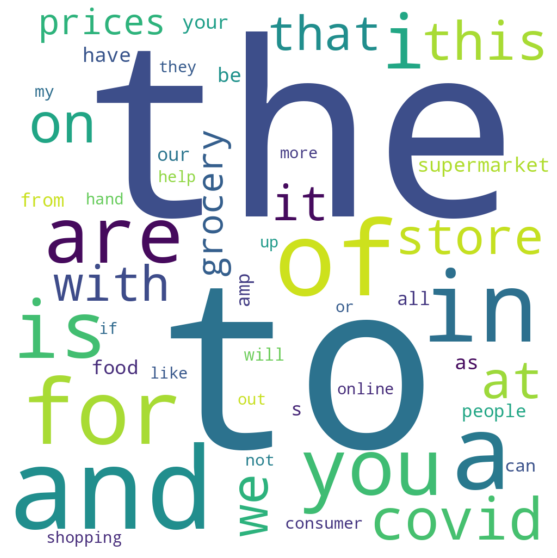

In [30]:
NB.plot_wordcloud(NaiveBayes.pos_tokens)

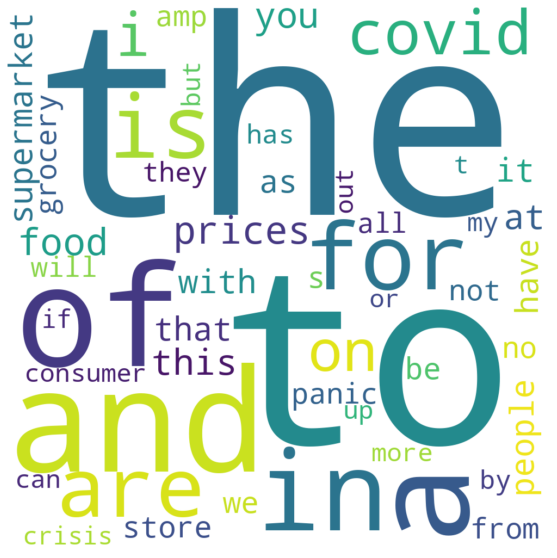

In [31]:
NB.plot_wordcloud(NaiveBayes.neg_tokens)

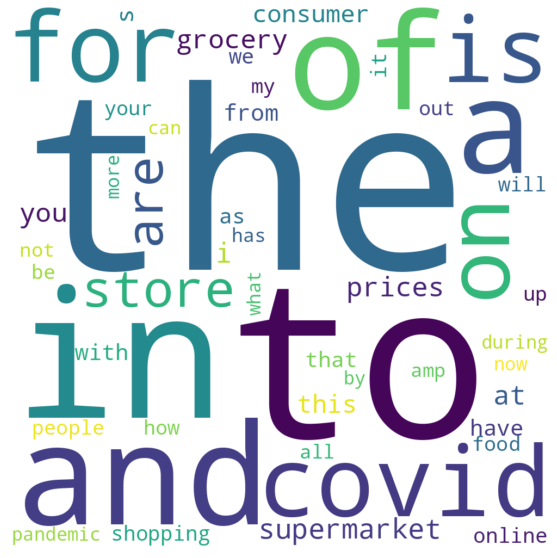

In [32]:
NB.plot_wordcloud(NaiveBayes.neu_tokens)

##### Random guessing 

In [33]:
test_df = test_df.reindex(columns=list(test_df.columns)+["Sentiment_pred_random"])
for i in range(len(test_df)):
    test_df.at[i,"Sentiment_pred_random"] = NB.num2str[random.randint(0,2)]

In [34]:
#Accuracy
acc = 0
for i in range(len(test_df)):
    if test_df["Sentiment"][i] == test_df["Sentiment_pred_random"][i]:
        acc += 1
acc = (acc*100)/len(test_df)
print("Accuracy: ", acc)

Accuracy:  32.15912541755238


##### Always Positive 

In [35]:
test_df = test_df.reindex(columns=list(test_df.columns)+["Sentiment_pred_positive"])
for i in range(len(test_df)):
    test_df.at[i,"Sentiment_pred_positive"] = "Positive"

In [36]:
#Accuracy
acc = 0
for i in range(len(test_df)):
    if test_df["Sentiment"][i] == test_df["Sentiment_pred_positive"][i]:
        acc += 1
acc = (acc*100)/len(test_df)
print("Accuracy: ", acc)

Accuracy:  43.850592165198904


##### Confusion Matrix

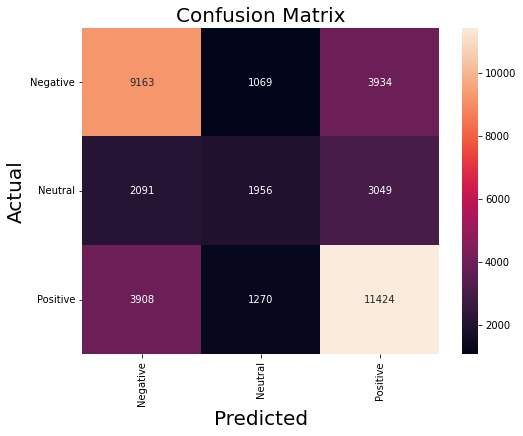

In [37]:
NB.confusion_matrix(train_df["Sentiment"], train_df["Sentiment_pred_initial"])

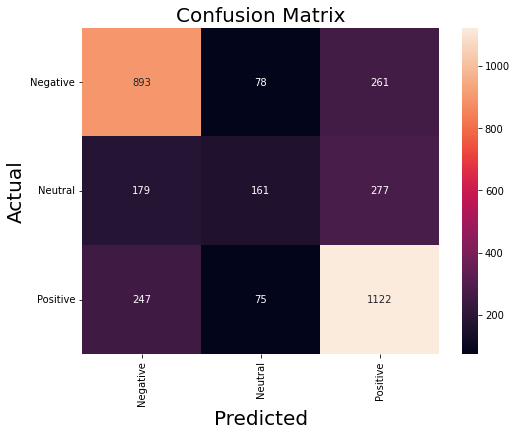

In [38]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_initial"])

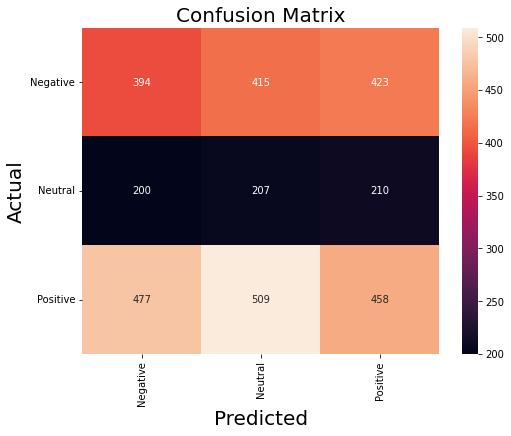

In [39]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_random"])

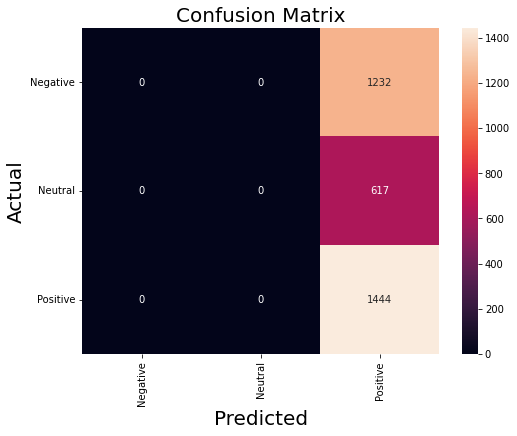

In [40]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_positive"])

#### Stemming and stopwords removal

In [81]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')
test_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_validation.csv')

In [82]:
NaiveBayes_ss = NB(train_df, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_ss.execute()

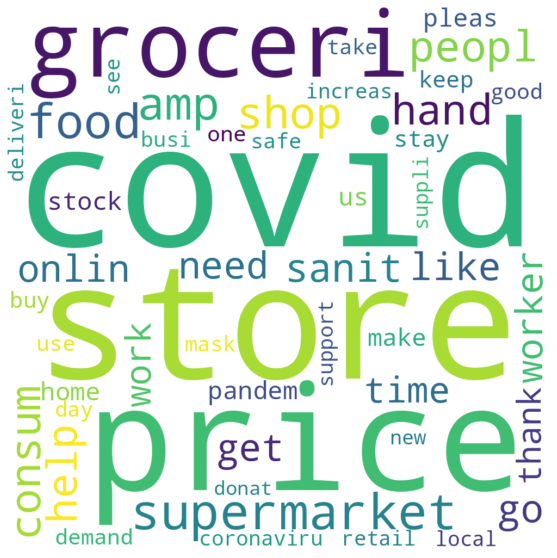

In [83]:
NB.plot_wordcloud(NaiveBayes_ss.pos_tokens)

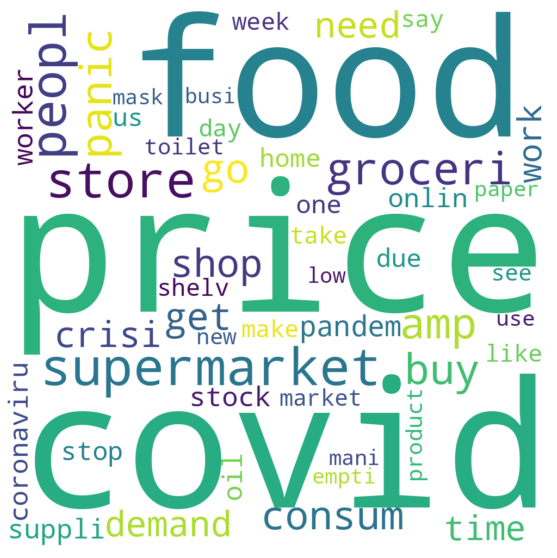

In [84]:
NB.plot_wordcloud(NaiveBayes_ss.neg_tokens)

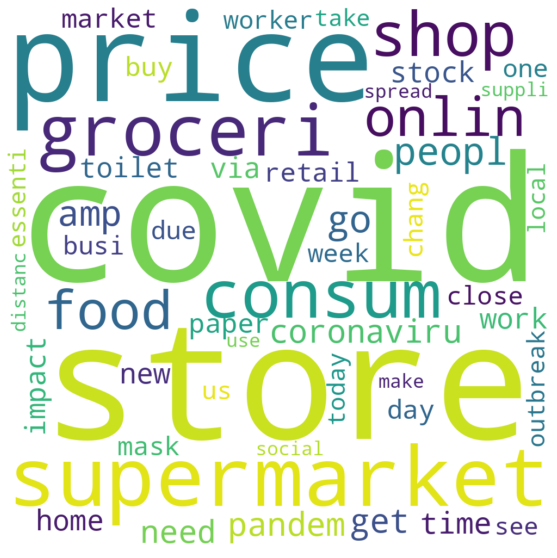

In [85]:
NB.plot_wordcloud(NaiveBayes_ss.neu_tokens)

In [86]:
train_df = NaiveBayes_ss.predict_on_testdata(train_df)

Accuracy:  62.750897950559896


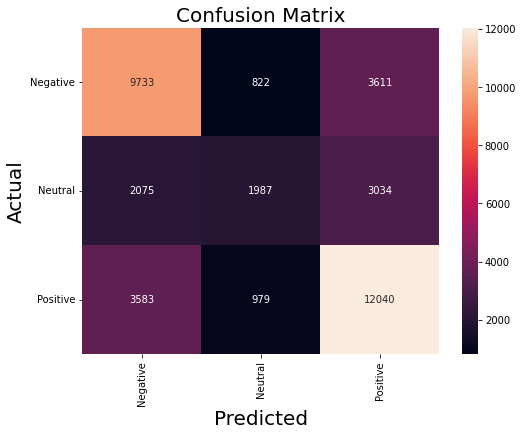

In [87]:
NB.confusion_matrix(train_df["Sentiment"], train_df["Sentiment_pred_initial"])

In [88]:
test_df = NaiveBayes_ss.predict_on_testdata(test_df)

Accuracy:  67.56756756756756


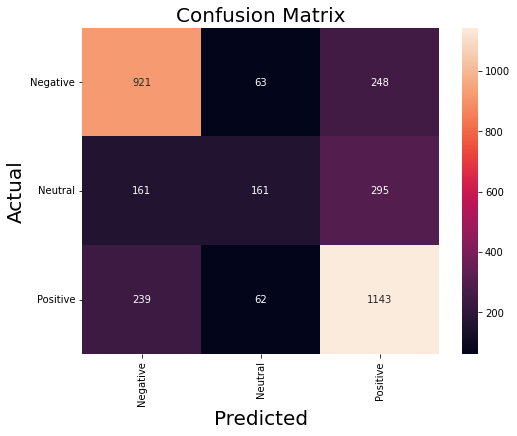

In [89]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_initial"])

### Bigram's Trigram's and WordScore(feature engineered)

#### Bigram's

In [53]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')
test_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_validation.csv')

In [54]:
NaiveBayes_bigram = NB(train_df, use_bigrams = True, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_bigram.execute()

In [55]:
train_df = NaiveBayes_bigram.predict_on_testdata(train_df)

Accuracy:  65.96503274878512


In [56]:
test_df = NaiveBayes_bigram.predict_on_testdata(test_df)

Accuracy:  66.47433950804738


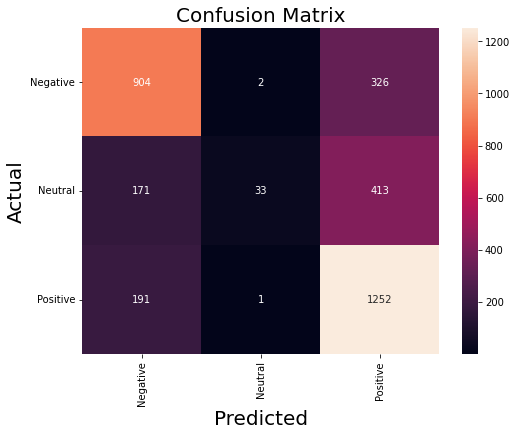

In [57]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_initial"])

#### Trigram's

In [61]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')
test_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_validation.csv')

In [62]:
NaiveBayes_trigram = NB(train_df, use_bigrams = True, use_trigrams = True, use_stem_remove_stopwords = True)
NaiveBayes_trigram.execute()

In [63]:
train_df = NaiveBayes_trigram.predict_on_testdata(train_df)

Accuracy:  83.19247834354532


In [64]:
test_df = NaiveBayes_trigram.predict_on_testdata(test_df)

Accuracy:  65.92772547828727


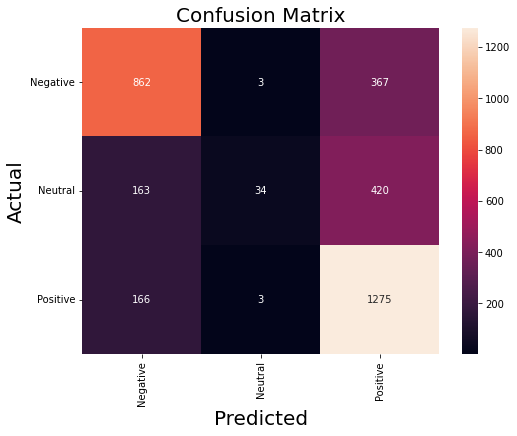

In [65]:
NB.confusion_matrix(test_df["Sentiment"], test_df["Sentiment_pred_initial"])

#### Word Score

In [78]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')
test_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_validation.csv')

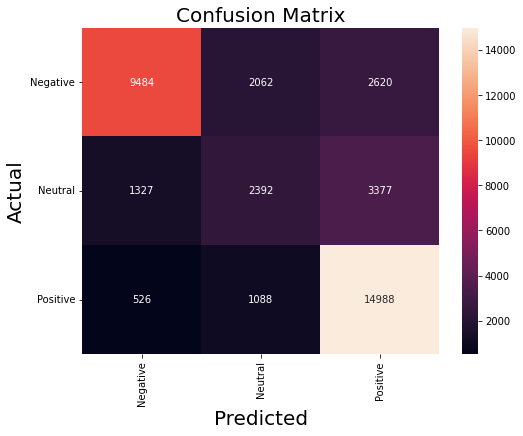

Accuracy:  70.94865835622227


In [79]:
WS = WordScore(train_df, NaiveBayes_ss.pos_tokens, NaiveBayes_ss.neu_tokens, NaiveBayes_ss.neg_tokens)
WS.execute_and_test(train_df)

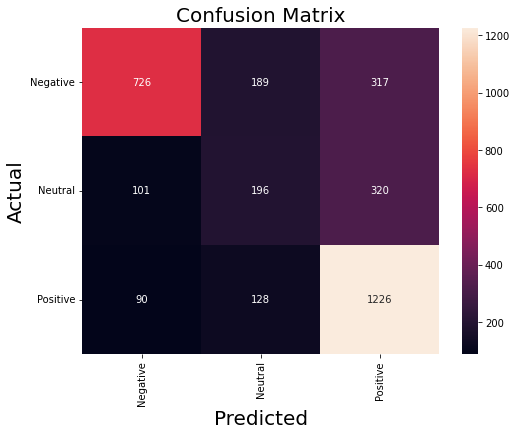

Accuracy:  65.22927421803826


In [80]:
WS.execute_and_test(test_df)

#### Domain Adaptation

In [136]:
train_df = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Corona_train.csv')

In [137]:
source = NB(train_df, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
source.execute()

##### 1% training data

In [138]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_1.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  43.10801855533466


##### 2% training data

In [139]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_2.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  43.70444002650762


##### 5% training data

In [140]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_5.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  45.891318754141814


##### 10% training data

In [141]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_10.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  47.28296885354539


##### 25% training data

In [142]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_25.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  49.370444002650764


##### 50% training data

In [143]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_50.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  51.25911199469848


##### 100% training data

In [144]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_100.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')


NaiveBayes_perc_da = NB_da(train_df_perc, train_df, source.pos_tokens, source.neu_tokens, source.neg_tokens, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True)
NaiveBayes_perc_da.execute()

test_df_da = NaiveBayes_perc_da.predict_on_testdata(test_df_da)

Accuracy:  52.61762756792578


#### Without Domain Adaptation

##### 1% training data

In [145]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_1.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  35.188866799204774


##### 2% training data

In [146]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_2.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  35.81842279655401


##### 5% training data

In [147]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_5.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  41.020543406229294


##### 10% training data

In [148]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_10.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  44.93041749502982


##### 25% training data

In [149]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_25.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  49.30417495029821


##### 50% training data

In [150]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_50.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  50.99403578528827


##### 100% training data

In [151]:
train_df_perc = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_train_100.csv')
test_df_da = pd.read_csv('/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 2/ML-A2/Domain_Adaptation/Twitter_validation.csv')

NaiveBayes2 = NB(train_df_perc, use_bigrams = False, use_trigrams = False, use_stem_remove_stopwords = True, da=True)
NaiveBayes2.execute()

test_df_da = NaiveBayes2.predict_on_testdata(test_df_da)

Accuracy:  53.445990722332674


##### Plotting validation accuracy on graph

In [169]:
x_label = ["1%","2%","5%","10%","25%","50%","100%"]
val_acc_without_da = [35.188866799204774, 
                   35.81842279655401, 
                   41.020543406229294, 
                   44.93041749502982, 
                   49.30417495029821, 
                   50.99403578528827, 
                   53.445990722332674]

val_acc_with_da = [43.10801855533466, 
                      43.70444002650762,
                      45.891318754141814, 
                      47.28296885354539, 
                      49.370444002650764, 
                      51.25911199469848, 
                      52.61762756792578]

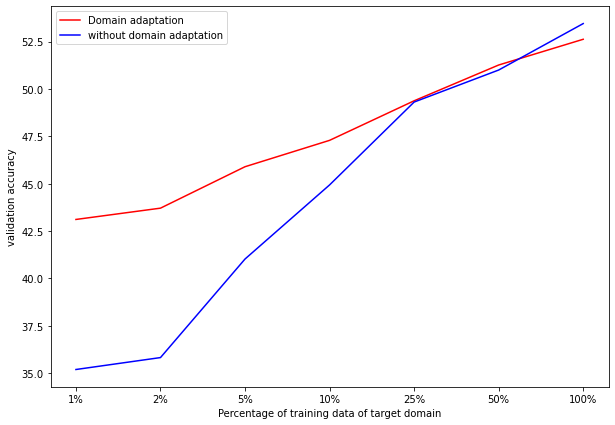

In [170]:
plt.figure(figsize=(10,7))
plt.plot(x_label,val_acc_with_da, color="red", label="Domain adaptation")
plt.plot(x_label,val_acc_without_da, color="blue", label="without domain adaptation")
plt.ylabel("validation accuracy")
plt.xlabel("Percentage of training data of target domain")
plt.legend()
plt.show()